Mix ai generated gemini 2.5 pro and thibault lootvoet + copilot

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sys
import os
import glob
import datetime

/home/thibaultlootvoet/projects/prc-challenge-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. Data Loading ---


def load_data():
    """Loads all parquet files and performs initial type conversion."""
    print("Loading data...")
    try:
        # Load the single-file datasets
        flights_df = pd.read_parquet("data/flightlist_train.parquet")
        fuel_df = pd.read_parquet("data/fuel_train.parquet")
        airports_df = pd.read_parquet("data/apt.parquet")

        print("Loaded flight list, fuel, and airport data.")

        # --- Load all trajectory files from the 'flights_train' directory ---

        traj_path = "data/flights_train"

        # Check if the directory exists
        if not os.path.isdir(traj_path):
            raise FileNotFoundError(
                f"Trajectory directory not found: '{traj_path}'. "
                "Please ensure it's in the same location as the script."
            )

        # Use glob to find all .parquet files in the directory
        all_traj_files = glob.glob(os.path.join(traj_path, "*.parquet"))

        # keep only the specified files for testing
        # all_traj_files = all_traj_files[start:end]

        if not all_traj_files:
            raise FileNotFoundError(
                f"No .parquet files found in '{traj_path}' directory."
            )

        print(
            f"Found {len(all_traj_files)} trajectory files. Loading and concatenating..."
        )

        # Create a list of dataframes, one for each file
        traj_dfs = [pd.read_parquet(f) for f in all_traj_files]

        # Concatenate all of them into a single dataframe
        traj_df = pd.concat(traj_dfs, ignore_index=True)

        print("Trajectory data concatenated successfully.")

        # --- 2. Data Preprocessing and Cleaning (same as before) ---
        print("Preprocessing data...")

        # Convert all relevant timestamps to datetime objects
        flights_df["takeoff"] = pd.to_datetime(flights_df["takeoff"])
        flights_df["landed"] = pd.to_datetime(flights_df["landed"])

        traj_df["timestamp"] = pd.to_datetime(traj_df["timestamp"])

        fuel_df["start"] = pd.to_datetime(fuel_df["start"])
        fuel_df["end"] = pd.to_datetime(fuel_df["end"])

        # "Quick and Dirty" cleaning: Drop flights with missing aircraft_type
        flights_df = flights_df.dropna(subset=["aircraft_type"])

        return flights_df, traj_df, fuel_df, airports_df

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print(
            "Please make sure all files (apt.parquet, flightlist_train.parquet, fuel_train.parquet) "
            "and the directory (flights_train/) are in the same location."
        )
        sys.exit(1)
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        print("You may need to install a parquet engine, e.g.: pip install pyarrow")
        sys.exit(1)

In [ ]:
# --- 3. Feature Engineering ---

def create_features(flights_df: pd.DataFrame, traj_df: pd.DataFrame, fuel_df: pd.DataFrame, airports_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, list]:
    """
    Engineers a model-ready feature set (X) and target (y) from the raw data.

    The core logic is built around the `fuel_df`, where each row represents
    a single fuel-burn interval and becomes one sample for the model.

    This function performs three main steps:
    1.  Merges Static Data: Enriches each fuel interval with static
        data from `flights_df` (e.g., aircraft_type) and `airports_df`
        (e.g., origin/destination elevation).
    2.  Filters & Aggregates Time-Series: For each interval, it finds all
        trajectory points from `traj_df` that fall *within* its [start, end]
        timestamp. It then aggregates these points to create summary
        statistics (e.g., mean_altitude, max_TAS, n_points).
    3.  Cleans & Finalizes: Calculates delta features (e.g., altitude_change),
        handles missing values, and formats the final feature matrix `X`
        and target vector `y`.

    Returns:
        X (pd.DataFrame): DataFrame of features for the model.
        y (pd.Series): Series of the target variable (fuel_kg).
        categorical_features (list): List of column names to be
                                     treated as categorical.
    """
    print("Engineering features...")

    # 3.1: Create base table from fuel data
    # Each row in fuel_df is our target sample
    data = fuel_df.copy()

    # 3.2: Add flight-level features
    data = pd.merge(data, flights_df[['flight_id', 'aircraft_type', 'origin_icao', 'destination_icao']], on='flight_id', how='left')

    # 3.3: Add airport features (elevation)
    airports_df_simple = airports_df[['icao', 'elevation']].rename(columns={'elevation': 'origin_elevation'})
    data = pd.merge(data, airports_df_simple, left_on='origin_icao', right_on='icao', how='left')
    airports_df_simple = airports_df_simple.rename(columns={'origin_elevation': 'dest_elevation'})
    data = pd.merge(data, airports_df_simple, left_on='destination_icao', right_on='icao', how='left')

    # 3.4: Engineer interval-based trajectory features (The complex part)
    
    # Give each interval a unique ID to group by
    data['interval_id'] = data.index

    # Merge all trajectory points with all intervals for the same flight
    # This creates a large table, but allows vectorized filtering.
    merged_traj = pd.merge(
        traj_df,
        data[['flight_id', 'start', 'end', 'interval_id']],
        on='flight_id'
    )

    # Filter: Keep only trajectory points that fall *within* the [start, end] of a fuel interval
    filtered_traj = merged_traj[
        (merged_traj['timestamp'] >= merged_traj['start']) &
        (merged_traj['timestamp'] <= merged_traj['end'])
    ].copy()

    # 3.5: Aggregate trajectory features by interval
    print("Aggregating trajectory features...")
    
    # Sort by time to get first/last points correctly
    filtered_traj.sort_values(by=['interval_id', 'timestamp'], inplace=True)

    # Simple aggregates
    agg_features = filtered_traj.groupby('interval_id').agg(
        mean_altitude=('altitude', 'mean'),
        max_altitude=('altitude', 'max'),
        mean_TAS=('TAS', 'mean'),
        max_TAS=('TAS', 'max'),
        mean_groundspeed=('groundspeed', 'mean'),
        mean_vertical_rate=('vertical_rate', 'mean'),
        n_points=('timestamp', 'count')
    )

    # Get features from the *first* and *last* point in the interval
    first_points = filtered_traj.groupby('interval_id').first()
    last_points = filtered_traj.groupby('interval_id').last()

    delta_features = pd.DataFrame(index=agg_features.index)
    delta_features['altitude_change'] = last_points['altitude'] - first_points['altitude']
    delta_features['time_in_interval_s'] = (last_points['timestamp'] - first_points['timestamp']).dt.total_seconds()

    # 3.6: Merge aggregated features back into the main table
    data = data.merge(agg_features, on='interval_id', how='left')
    data = data.merge(delta_features, on='interval_id', how='left')

    # 3.7: Add simple features
    # This is the 'reported' duration, which is a key predictor
    data['interval_duration_s'] = (data['end'] - data['start']).dt.total_seconds()

    # --- 4. Final Processing ---
    print("Finalizing dataset...")

    # Define feature set
    # We must convert aircraft_type to a category for LightGBM
    data['aircraft_type'] = data['aircraft_type'].astype('category')
    
    # "Quick and Dirty" cleaning:
    # Drop rows where we have no fuel target
    data = data.dropna(subset=['fuel_kg'])
    # Drop rows where interval duration is zero or negative
    data = data[data['interval_duration_s'] > 0]
    # Drop intervals that had no trajectory points (n_points is NaN after left merge)
    data = data.dropna(subset=['n_points'])

    # Fill any other remaining NaNs (e.g., missing TAS) with 0
    # A better approach would be interpolation or 0-filling only specific columns
    # Step 1: Handle the categorical column ('aircraft_type').
    # Convert it to a standard 'object' (string) column first. This "unlocks" it.
    data['aircraft_type'] = data['aircraft_type'].astype('object')
    
    # Step 2: Now that it's a simple object column, fill the NaNs.
    # We use 'UNKNOWN' as the placeholder.
    data['aircraft_type'] = data['aircraft_type'].fillna("UNKNOWN")
    
    # Step 3: Convert the fully-filled column back to 'category'.
    # Pandas will now see 'UNKNOWN' as one of the valid categories.
    data['aircraft_type'] = data['aircraft_type'].astype('category')

    # Step 4: Now, fill all remaining *numeric* columns with 0.
    numeric_cols = data.select_dtypes(include=np.number).columns
    data[numeric_cols] = data[numeric_cols].fillna(0)

    features = [
        'interval_duration_s', 'aircraft_type', 'origin_elevation', 'dest_elevation',
        'mean_altitude', 'max_altitude', 'mean_TAS', 'max_TAS',
        'mean_groundspeed', 'mean_vertical_rate', 'n_points',
        'altitude_change', 'time_in_interval_s'
    ]
    categorical_features = ['aircraft_type']
    target = 'fuel_kg'

    # Filter out any rows that somehow still have NaN/Inf in features
    X = data[features]
    y = data[target]
    
    # Define our numeric features (which is all features *except* the categorical ones)
    numeric_features = [f for f in features if f not in categorical_features]

    # Apply numeric-only cleaning (replace inf, fillna) 
    # ONLY to the numeric columns.
    X[numeric_features] = X[numeric_features].replace([np.inf, -np.inf], np.nan).fillna(0)

    print(f"Dataset finalized. Total samples: {len(X)}")
    print(f"Features: {features}")
    
    display(X.head())
    display(y.head())
    print(f"Categorical features: {categorical_features}")

    return X, y, categorical_features

In [ ]:
# --- 5. Model Training with Optuna ---


def train_model(X, y, categorical_features, n_trials=50, to_load=None):
    """Sets up Optuna to find the best LightGBM hyperparameters."""

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    def objective(trial):
        """Optuna objective function to minimize."""

        # Hyperparameters to tune
        params = {
            "objective": "regression_l1",  # MAE is less sensitive to outliers than MSE (L2)
            "metric": "rmse",
            "n_estimators": 1000,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "verbose": -1,
            "n_jobs": -1,
            "seed": 42,
        }

        model = lgb.LGBMRegressor(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(100, verbose=False)],
            categorical_feature=categorical_features,
        )

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse

    print("\n--- Starting Optuna Hyperparameter Search ---")
    if to_load:
        study = optuna.load_study(study_name=to_load, storage="sqlite:///db.sqlite3")
        print(f"Loaded existing study '{to_load}' with {len(study.trials)} trials.")
    else:
        study = optuna.create_study(direction="minimize", study_name=f"LightGBM Fuel Burn Prediction {datetime.datetime.now().isoformat()}", storage="sqlite:///db.sqlite3", load_if_exists=True)

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nOptuna search finished.")
    print(f"Best RMSE on validation set: {study.best_value:.4f}")
    print("Best hyperparameters:")
    print(study.best_params)

    # --- 6. Final Model Evaluation ---
    print("\n--- Training Final Model on All Training Data ---")

    # Add n_estimators from the best trial (or use the fitted one from early stopping)
    best_params = study.best_params
    best_params["n_estimators"] = 1000  # We will use early stopping

    final_model = lgb.LGBMRegressor(
        objective="regression_l1",
        metric="rmse",
        seed=42,
        n_jobs=-1,
        verbose=-1,
        **best_params,
    )

    final_model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(100, verbose=True)],
        categorical_feature=categorical_features,
    )

    val_preds = final_model.predict(X_val)
    final_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"\nFinal Model Validation RMSE: {final_rmse:.4f}")

    # Show feature importances
    try:
        lgb.plot_importance(final_model, max_num_features=20)
        import matplotlib.pyplot as plt

        plt.title("Feature Importances")
        plt.savefig("feature_importance.png", bbox_inches="tight")
        print("\nSaved feature importance plot to 'feature_importance.png'")
    except Exception as e:
        print(
            f"\nCould not plot feature importance. (Is matplotlib installed?) Error: {e}"
        )

In [ ]:
def test_model(X, y, categorical_features, model_to_load):
    """Loads the best model from the Optuna study."""
    study = optuna.load_study(study_name=model_to_load, storage="sqlite:///db.sqlite3")
    best_trial = study.best_trial
    print(f"Best trial: {best_trial.number}")
    print(f"Best value (RMSE): {best_trial.value:.4f}")
    print("Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")

    # Train final model with best hyperparameters
    final_model = lgb.LGBMRegressor(best_trial.params)
    final_model.fit(X, y, categorical_feature=categorical_features)

    # print rmse on the training set
    train_preds = final_model.predict(X)
    train_rmse = np.sqrt(mean_squared_error(y, train_preds))
    print(f"\nFinal Model Training RMSE: {train_rmse:.4f}")
    
    # Show feature importances
    try:
        lgb.plot_importance(final_model, max_num_features=20)
        import matplotlib.pyplot as plt

        plt.title("Feature Importances")
        plt.savefig("feature_importance.png", bbox_inches="tight")
        print("\nSaved feature importance plot to 'feature_importance.png'")
    except Exception as e:
        print(
            f"\nCould not plot feature importance. (Is matplotlib installed?) Error: {e}"
        )

In [6]:
# nécessité de faire du feature engineering i.e. prendre des moyennes ou qqch parce que là ce n'est pas possible
# approche actuelle: https://gemini.google.com/app/2db88ca378891ac5

In [7]:
flights, traj, fuel, airports = load_data()

Loading data...
Loaded flight list, fuel, and airport data.
Found 5868 trajectory files. Loading and concatenating...
Trajectory data concatenated successfully.
Preprocessing data...


In [ ]:
# keep only the first 100 rows of fuel for faster testing
# fuel_short = fuel.iloc[:200].reset_index(drop=True)
# fuel_short = fuel.copy()

X_features, y_target, categorical_cols = create_features(flights, traj, fuel, airports)
train_model(X_features, y_target, categorical_cols, n_trials=100)
# load_model(X_features, y_target, categorical_cols, model_to_load="LightGBM Fuel Burn Prediction 2025-10-28T21:03:59.935861")

Engineering features...
Aggregating trajectory features...
Finalizing dataset...
Dataset finalized. Total samples: 121
Features: ['interval_duration_s', 'aircraft_type', 'origin_elevation', 'dest_elevation', 'mean_altitude', 'max_altitude', 'mean_TAS', 'max_TAS', 'mean_groundspeed', 'mean_vertical_rate', 'n_points', 'altitude_change', 'time_in_interval_s']


/tmp/ipykernel_3644/3958073339.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = X[numeric_features].replace([np.inf, -np.inf], np.nan).fillna(0)


,interval_duration_s,aircraft_type,origin_elevation,dest_elevation,mean_altitude,max_altitude,mean_TAS,max_TAS,mean_groundspeed,mean_vertical_rate,n_points,altitude_change,time_in_interval_s
0,1800.040,B789,69.0,-11.0,35988.585001,35999.9280,0.0,0.0,472.013723,-3.360382,3078.0,24.9936,1800.040
1,899.739,B789,69.0,-11.0,35989.290344,35999.9280,0.0,0.0,484.703549,-29.862213,1790.0,-24.9936,899.739
2,1799.959,B789,69.0,-11.0,35988.990605,35999.9280,0.0,0.0,511.885794,-36.040854,3480.0,0.0000,1799.959
3,900.123,B789,69.0,-11.0,35988.474983,36024.9216,0.0,0.0,506.388982,-34.457429,1750.0,24.9936,900.123
4,899.723,B789,69.0,-11.0,29491.527367,35999.9280,0.0,0.0,467.748289,-1531.863118,1518.0,-20774.8632,899.723


0    2500.0
1    1200.0
2    2500.0
3    1300.0
4     600.0
Name: fuel_kg, dtype: float64

Categorical features: ['aircraft_type']


Best trial: 188
Best value (RMSE): 317.9822
Best hyperparameters:
  learning_rate: 0.1099350251039737
  num_leaves: 239
  max_depth: 15
  subsample: 0.8439209077241189
  colsample_bytree: 0.7028359161508971
  reg_alpha: 0.6883146911205672
  reg_lambda: 0.5517410580422722

Final Model Training RMSE: 652.0977

Saved feature importance plot to 'feature_importance.png'


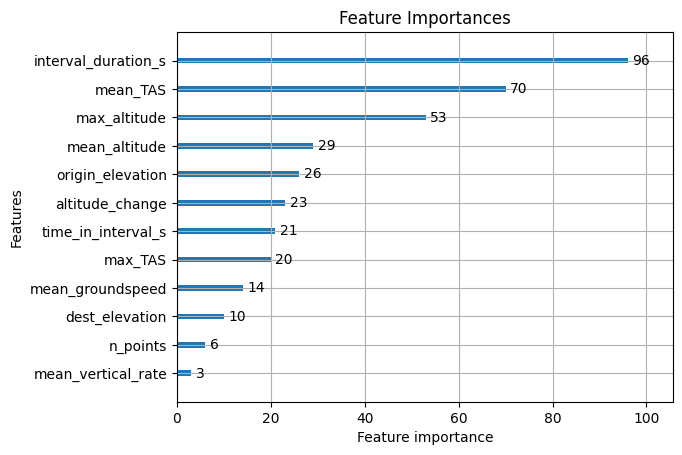

In [11]:
test_model(X_features, y_target, categorical_cols, model_to_load="LightGBM Fuel Burn Prediction 2025-10-30T12:42:38.153171")


--- Starting Optuna Hyperparameter Search ---
Loaded existing study 'LightGBM Fuel Burn Prediction 2025-10-30T12:42:38.153171' with 164 trials.


Best trial: 126. Best value: 319.342:   2%|▏         | 1/50 [00:18<15:25, 18.88s/it]

[I 2025-10-30 14:10:17,710] Trial 164 finished with value: 338.73756040079525 and parameters: {'learning_rate': 0.10563216239471968, 'num_leaves': 54, 'max_depth': 10, 'subsample': 0.6170127180711842, 'colsample_bytree': 0.7379166396670968, 'reg_alpha': 0.7345409499091471, 'reg_lambda': 0.803091839215571}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:   4%|▍         | 2/50 [00:38<15:41, 19.61s/it]

[I 2025-10-30 14:10:37,826] Trial 165 finished with value: 325.45008025451426 and parameters: {'learning_rate': 0.11360133308911186, 'num_leaves': 63, 'max_depth': 17, 'subsample': 0.6655934704599421, 'colsample_bytree': 0.7014722046287609, 'reg_alpha': 0.6659403576039308, 'reg_lambda': 0.5197792409064267}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:   6%|▌         | 3/50 [00:56<14:37, 18.67s/it]

[I 2025-10-30 14:10:55,388] Trial 166 finished with value: 322.0111504177821 and parameters: {'learning_rate': 0.12126653615412113, 'num_leaves': 221, 'max_depth': 15, 'subsample': 0.8168936244622583, 'colsample_bytree': 0.6887492185530726, 'reg_alpha': 0.7498034992805871, 'reg_lambda': 0.4742708741406232}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:   8%|▊         | 4/50 [01:14<14:11, 18.51s/it]

[I 2025-10-30 14:11:13,637] Trial 167 finished with value: 323.003486684865 and parameters: {'learning_rate': 0.12169764071305351, 'num_leaves': 218, 'max_depth': 16, 'subsample': 0.8201169409913666, 'colsample_bytree': 0.6890835895548011, 'reg_alpha': 0.7479726510969993, 'reg_lambda': 0.4768437911874363}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:  10%|█         | 5/50 [01:30<13:13, 17.64s/it]

[I 2025-10-30 14:11:29,747] Trial 168 finished with value: 329.32683930377186 and parameters: {'learning_rate': 0.13017464948968946, 'num_leaves': 226, 'max_depth': 15, 'subsample': 0.8078260964008424, 'colsample_bytree': 0.6879440333351351, 'reg_alpha': 0.75435608601635, 'reg_lambda': 0.467414477857814}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:  12%|█▏        | 6/50 [01:46<12:28, 17.01s/it]

[I 2025-10-30 14:11:45,529] Trial 169 finished with value: 330.43166779200783 and parameters: {'learning_rate': 0.12037372630264341, 'num_leaves': 221, 'max_depth': 16, 'subsample': 0.79782891046152, 'colsample_bytree': 0.6711929634023517, 'reg_alpha': 0.7698590264170124, 'reg_lambda': 0.4319582178942842}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:  14%|█▍        | 7/50 [01:59<11:13, 15.67s/it]

[I 2025-10-30 14:11:58,450] Trial 170 finished with value: 325.3529137858563 and parameters: {'learning_rate': 0.14062064681883507, 'num_leaves': 215, 'max_depth': 16, 'subsample': 0.8184620890549754, 'colsample_bytree': 0.6791050589765851, 'reg_alpha': 0.7867127484024838, 'reg_lambda': 0.4771474383869173}. Best is trial 126 with value: 319.34158284062005.


Best trial: 126. Best value: 319.342:  16%|█▌        | 8/50 [02:21<12:24, 17.72s/it]

[I 2025-10-30 14:12:20,569] Trial 171 finished with value: 319.4690340484146 and parameters: {'learning_rate': 0.10842689677382926, 'num_leaves': 224, 'max_depth': 15, 'subsample': 0.8327366061833066, 'colsample_bytree': 0.6909201868557594, 'reg_alpha': 0.7182693324621635, 'reg_lambda': 0.5560180225665605}. Best is trial 126 with value: 319.34158284062005.


Best trial: 172. Best value: 318.336:  18%|█▊        | 9/50 [02:45<13:18, 19.47s/it]

[I 2025-10-30 14:12:43,884] Trial 172 finished with value: 318.3355553378276 and parameters: {'learning_rate': 0.10965359131685357, 'num_leaves': 235, 'max_depth': 15, 'subsample': 0.8293582267794962, 'colsample_bytree': 0.6915111240875115, 'reg_alpha': 0.7164154060085736, 'reg_lambda': 0.5054206473246219}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  20%|██        | 10/50 [03:03<12:52, 19.30s/it]

[I 2025-10-30 14:13:02,804] Trial 173 finished with value: 320.93433061377686 and parameters: {'learning_rate': 0.10839926272698494, 'num_leaves': 75, 'max_depth': 15, 'subsample': 0.8302323871778536, 'colsample_bytree': 0.699545559046782, 'reg_alpha': 0.7195830614594211, 'reg_lambda': 0.5624048909107965}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  22%|██▏       | 11/50 [03:23<12:31, 19.26s/it]

[I 2025-10-30 14:13:21,978] Trial 174 finished with value: 331.0861096590757 and parameters: {'learning_rate': 0.1040356932027743, 'num_leaves': 241, 'max_depth': 14, 'subsample': 0.831175153835276, 'colsample_bytree': 0.6959996171741978, 'reg_alpha': 0.7047027377592899, 'reg_lambda': 0.5535545777238312}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  24%|██▍       | 12/50 [03:37<11:19, 17.87s/it]

[I 2025-10-30 14:13:36,672] Trial 175 finished with value: 321.1646605668509 and parameters: {'learning_rate': 0.11015502004921589, 'num_leaves': 235, 'max_depth': 15, 'subsample': 0.8136653274090617, 'colsample_bytree': 0.7031112224775633, 'reg_alpha': 0.7165738660909865, 'reg_lambda': 0.5688376855578112}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  26%|██▌       | 13/50 [03:57<11:25, 18.52s/it]

[I 2025-10-30 14:13:56,680] Trial 176 finished with value: 337.64528115549865 and parameters: {'learning_rate': 0.09551974888017055, 'num_leaves': 238, 'max_depth': 15, 'subsample': 0.8124207489938489, 'colsample_bytree': 0.7021857308811081, 'reg_alpha': 0.7345577329947837, 'reg_lambda': 0.5657206600600245}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  28%|██▊       | 14/50 [04:22<12:09, 20.25s/it]

[I 2025-10-30 14:14:20,929] Trial 177 finished with value: 319.34141153057294 and parameters: {'learning_rate': 0.10967180587980377, 'num_leaves': 248, 'max_depth': 15, 'subsample': 0.8387203593500685, 'colsample_bytree': 0.7087848829949138, 'reg_alpha': 0.6915216805629738, 'reg_lambda': 0.5913204408683792}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  30%|███       | 15/50 [04:38<11:09, 19.13s/it]

[I 2025-10-30 14:14:37,457] Trial 178 finished with value: 321.2045519294779 and parameters: {'learning_rate': 0.10917851126236591, 'num_leaves': 236, 'max_depth': 15, 'subsample': 0.8361470363992136, 'colsample_bytree': 0.7060968835950228, 'reg_alpha': 0.6891133971489568, 'reg_lambda': 0.5892497070014031}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  32%|███▏      | 16/50 [05:00<11:20, 20.02s/it]

[I 2025-10-30 14:14:59,541] Trial 179 finished with value: 319.96855516255323 and parameters: {'learning_rate': 0.1099602816672814, 'num_leaves': 250, 'max_depth': 15, 'subsample': 0.846259915263622, 'colsample_bytree': 0.6896493229906678, 'reg_alpha': 0.7174154761067751, 'reg_lambda': 0.6020610834704114}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  34%|███▍      | 17/50 [05:16<10:21, 18.82s/it]

[I 2025-10-30 14:15:15,578] Trial 180 finished with value: 320.7604728700101 and parameters: {'learning_rate': 0.1085169649423249, 'num_leaves': 247, 'max_depth': 15, 'subsample': 0.8474760200100667, 'colsample_bytree': 0.7092501609485901, 'reg_alpha': 0.7170557876042469, 'reg_lambda': 0.5924390045689123}. Best is trial 172 with value: 318.3355553378276.


Best trial: 172. Best value: 318.336:  36%|███▌      | 18/50 [05:34<09:49, 18.43s/it]

[I 2025-10-30 14:15:33,103] Trial 181 finished with value: 344.19926138647116 and parameters: {'learning_rate': 0.08643482936788607, 'num_leaves': 249, 'max_depth': 15, 'subsample': 0.8500345600131446, 'colsample_bytree': 0.7087946664955419, 'reg_alpha': 0.7190776311055854, 'reg_lambda': 0.6357334765890127}. Best is trial 172 with value: 318.3355553378276.


Best trial: 182. Best value: 318.195:  38%|███▊      | 19/50 [06:03<11:11, 21.65s/it]

[I 2025-10-30 14:16:02,238] Trial 182 finished with value: 318.1949035969589 and parameters: {'learning_rate': 0.10886449644067919, 'num_leaves': 233, 'max_depth': 15, 'subsample': 0.8454060523944552, 'colsample_bytree': 0.7196178539388778, 'reg_alpha': 0.7030139870573251, 'reg_lambda': 0.5981806157157152}. Best is trial 182 with value: 318.1949035969589.


Best trial: 182. Best value: 318.195:  40%|████      | 20/50 [06:17<09:43, 19.44s/it]

[I 2025-10-30 14:16:16,530] Trial 183 finished with value: 336.4898361382559 and parameters: {'learning_rate': 0.100862734978842, 'num_leaves': 233, 'max_depth': 15, 'subsample': 0.8429139184253487, 'colsample_bytree': 0.6951383886687993, 'reg_alpha': 0.6925085167707918, 'reg_lambda': 0.5880408495359724}. Best is trial 182 with value: 318.1949035969589.


Best trial: 182. Best value: 318.195:  42%|████▏     | 21/50 [06:35<09:13, 19.09s/it]

[I 2025-10-30 14:16:34,800] Trial 184 finished with value: 320.23046398468705 and parameters: {'learning_rate': 0.11007011328744505, 'num_leaves': 257, 'max_depth': 14, 'subsample': 0.8283209648135683, 'colsample_bytree': 0.7049724587409312, 'reg_alpha': 0.7162369560507527, 'reg_lambda': 0.5941053692381867}. Best is trial 182 with value: 318.1949035969589.


Best trial: 182. Best value: 318.195:  44%|████▍     | 22/50 [06:52<08:33, 18.32s/it]

[I 2025-10-30 14:16:51,336] Trial 185 finished with value: 327.681912881804 and parameters: {'learning_rate': 0.11208730230819526, 'num_leaves': 255, 'max_depth': 15, 'subsample': 0.8580717822859054, 'colsample_bytree': 0.7072478781367477, 'reg_alpha': 0.6930587087472334, 'reg_lambda': 0.6030526118656612}. Best is trial 182 with value: 318.1949035969589.


Best trial: 182. Best value: 318.195:  46%|████▌     | 23/50 [07:07<07:51, 17.45s/it]

[I 2025-10-30 14:17:06,742] Trial 186 finished with value: 331.4297849821301 and parameters: {'learning_rate': 0.10354562912474911, 'num_leaves': 267, 'max_depth': 14, 'subsample': 0.8296302687124918, 'colsample_bytree': 0.6832674616992415, 'reg_alpha': 0.7315712758340485, 'reg_lambda': 0.5896389749360246}. Best is trial 182 with value: 318.1949035969589.


Best trial: 182. Best value: 318.195:  48%|████▊     | 24/50 [07:29<08:09, 18.82s/it]

[I 2025-10-30 14:17:28,754] Trial 187 finished with value: 345.68349071931056 and parameters: {'learning_rate': 0.09278908281789236, 'num_leaves': 260, 'max_depth': 15, 'subsample': 0.8656536179633161, 'colsample_bytree': 0.694653489044343, 'reg_alpha': 0.7116878134720193, 'reg_lambda': 0.6615381629323709}. Best is trial 182 with value: 318.1949035969589.


Best trial: 188. Best value: 317.982:  50%|█████     | 25/50 [07:57<08:56, 21.48s/it]

[I 2025-10-30 14:17:56,432] Trial 188 finished with value: 317.98223863555756 and parameters: {'learning_rate': 0.1099350251039737, 'num_leaves': 239, 'max_depth': 15, 'subsample': 0.8439209077241189, 'colsample_bytree': 0.7028359161508971, 'reg_alpha': 0.6883146911205672, 'reg_lambda': 0.5517410580422722}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  52%|█████▏    | 26/50 [08:11<07:42, 19.25s/it]

[I 2025-10-30 14:18:10,507] Trial 189 finished with value: 338.4378429037417 and parameters: {'learning_rate': 0.09834868412502917, 'num_leaves': 242, 'max_depth': 15, 'subsample': 0.8488919277111531, 'colsample_bytree': 0.7100685965619048, 'reg_alpha': 0.6595192071929074, 'reg_lambda': 0.5504389279602968}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  54%|█████▍    | 27/50 [08:25<06:48, 17.75s/it]

[I 2025-10-30 14:18:24,750] Trial 190 finished with value: 327.50699308111547 and parameters: {'learning_rate': 0.11152694479534872, 'num_leaves': 246, 'max_depth': 14, 'subsample': 0.8362428547366415, 'colsample_bytree': 0.7212150830335871, 'reg_alpha': 0.6848890496105375, 'reg_lambda': 0.5982979144694257}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  56%|█████▌    | 28/50 [08:42<06:20, 17.29s/it]

[I 2025-10-30 14:18:40,966] Trial 191 finished with value: 334.3109798218467 and parameters: {'learning_rate': 0.10199798714220173, 'num_leaves': 251, 'max_depth': 15, 'subsample': 0.8255904273427946, 'colsample_bytree': 0.6914935641178785, 'reg_alpha': 0.7149233205581087, 'reg_lambda': 0.6208802158176528}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  58%|█████▊    | 29/50 [09:14<07:36, 21.74s/it]

[I 2025-10-30 14:19:13,088] Trial 192 finished with value: 319.2838810957431 and parameters: {'learning_rate': 0.11102462995569043, 'num_leaves': 239, 'max_depth': 15, 'subsample': 0.8426615302629317, 'colsample_bytree': 0.7020016426086548, 'reg_alpha': 0.29060221676670983, 'reg_lambda': 0.5368595044007534}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  60%|██████    | 30/50 [09:27<06:24, 19.24s/it]

[I 2025-10-30 14:19:26,490] Trial 193 finished with value: 325.9036577790168 and parameters: {'learning_rate': 0.10836447932388053, 'num_leaves': 240, 'max_depth': 15, 'subsample': 0.8413536479942015, 'colsample_bytree': 0.7016939827564735, 'reg_alpha': 0.2887007519315941, 'reg_lambda': 0.5710772998372318}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  62%|██████▏   | 31/50 [09:41<05:31, 17.47s/it]

[I 2025-10-30 14:19:39,841] Trial 194 finished with value: 324.94875875153417 and parameters: {'learning_rate': 0.1131447870683448, 'num_leaves': 233, 'max_depth': 15, 'subsample': 0.8574525653985535, 'colsample_bytree': 0.7129138207206793, 'reg_alpha': 0.6910236783036205, 'reg_lambda': 0.5420896761351637}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  64%|██████▍   | 32/50 [09:59<05:18, 17.72s/it]

[I 2025-10-30 14:19:58,123] Trial 195 finished with value: 329.52545275595133 and parameters: {'learning_rate': 0.1050789481540159, 'num_leaves': 245, 'max_depth': 14, 'subsample': 0.8455455110651435, 'colsample_bytree': 0.6817983082336946, 'reg_alpha': 0.0698526698623208, 'reg_lambda': 0.531989774435408}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  66%|██████▌   | 33/50 [10:14<04:46, 16.87s/it]

[I 2025-10-30 14:20:13,010] Trial 196 finished with value: 337.51980484328357 and parameters: {'learning_rate': 0.09116461668980941, 'num_leaves': 235, 'max_depth': 14, 'subsample': 0.8346351232943539, 'colsample_bytree': 0.7048103765184249, 'reg_alpha': 0.39180793497428645, 'reg_lambda': 0.6354984038558997}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  68%|██████▊   | 34/50 [10:33<04:40, 17.51s/it]

[I 2025-10-30 14:20:32,021] Trial 197 finished with value: 327.68511501209707 and parameters: {'learning_rate': 0.11210616175000253, 'num_leaves': 276, 'max_depth': 15, 'subsample': 0.8262220183965758, 'colsample_bytree': 0.6963186586773911, 'reg_alpha': 0.669815361885912, 'reg_lambda': 0.5844958563509691}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  70%|███████   | 35/50 [10:57<04:51, 19.41s/it]

[I 2025-10-30 14:20:55,881] Trial 198 finished with value: 341.8132038623854 and parameters: {'learning_rate': 0.09947008031238355, 'num_leaves': 257, 'max_depth': 14, 'subsample': 0.86917905598344, 'colsample_bytree': 0.7202966309623888, 'reg_alpha': 0.719189475766386, 'reg_lambda': 0.5603559645727463}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  72%|███████▏  | 36/50 [11:12<04:16, 18.32s/it]

[I 2025-10-30 14:21:11,659] Trial 199 finished with value: 326.0839439355847 and parameters: {'learning_rate': 0.1055123490359816, 'num_leaves': 249, 'max_depth': 15, 'subsample': 0.8534894992162168, 'colsample_bytree': 0.7078142157453036, 'reg_alpha': 0.6525839239126525, 'reg_lambda': 0.6084669083632185}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  74%|███████▍  | 37/50 [11:33<04:08, 19.12s/it]

[I 2025-10-30 14:21:32,641] Trial 200 finished with value: 324.404734869086 and parameters: {'learning_rate': 0.11514467049523393, 'num_leaves': 265, 'max_depth': 15, 'subsample': 0.8041864302410922, 'colsample_bytree': 0.6879990043349465, 'reg_alpha': 0.7378991775900821, 'reg_lambda': 0.5138842377433082}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  76%|███████▌  | 38/50 [11:48<03:34, 17.91s/it]

[I 2025-10-30 14:21:47,730] Trial 201 finished with value: 320.3160826954614 and parameters: {'learning_rate': 0.10898097342691893, 'num_leaves': 240, 'max_depth': 16, 'subsample': 0.8374197740050957, 'colsample_bytree': 0.7012269609950497, 'reg_alpha': 0.7065756770328304, 'reg_lambda': 0.5635169463507851}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  78%|███████▊  | 39/50 [12:47<05:32, 30.18s/it]

[I 2025-10-30 14:22:46,550] Trial 202 finished with value: 350.0869956702679 and parameters: {'learning_rate': 0.01212228262675466, 'num_leaves': 238, 'max_depth': 16, 'subsample': 0.8425578836325782, 'colsample_bytree': 0.700446583959578, 'reg_alpha': 0.7005296639479931, 'reg_lambda': 0.5658106317039242}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  80%|████████  | 40/50 [13:00<04:10, 25.03s/it]

[I 2025-10-30 14:22:59,545] Trial 203 finished with value: 329.4339910188059 and parameters: {'learning_rate': 0.10935687450413013, 'num_leaves': 228, 'max_depth': 15, 'subsample': 0.8317895361008012, 'colsample_bytree': 0.714544266749862, 'reg_alpha': 0.19775829891652225, 'reg_lambda': 0.549009325405527}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  82%|████████▏ | 41/50 [13:18<03:26, 22.94s/it]

[I 2025-10-30 14:23:17,628] Trial 204 finished with value: 333.848035868583 and parameters: {'learning_rate': 0.10198367077885427, 'num_leaves': 242, 'max_depth': 16, 'subsample': 0.8216022061376461, 'colsample_bytree': 0.6948077061603241, 'reg_alpha': 0.6849460447669734, 'reg_lambda': 0.5940409241258676}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  84%|████████▍ | 42/50 [13:32<02:40, 20.10s/it]

[I 2025-10-30 14:23:31,105] Trial 205 finished with value: 325.3913656742908 and parameters: {'learning_rate': 0.11520712147231367, 'num_leaves': 254, 'max_depth': 14, 'subsample': 0.8497946468459572, 'colsample_bytree': 0.7061881150373416, 'reg_alpha': 0.7145713862289184, 'reg_lambda': 0.5311315889444632}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  86%|████████▌ | 43/50 [13:54<02:24, 20.61s/it]

[I 2025-10-30 14:23:52,888] Trial 206 finished with value: 320.85467888561556 and parameters: {'learning_rate': 0.10809512637859635, 'num_leaves': 229, 'max_depth': 15, 'subsample': 0.8362710292430919, 'colsample_bytree': 0.6820487279036278, 'reg_alpha': 0.7367975606382742, 'reg_lambda': 0.5745368161697032}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  88%|████████▊ | 44/50 [14:13<02:02, 20.37s/it]

[I 2025-10-30 14:24:12,710] Trial 207 finished with value: 343.7320726800356 and parameters: {'learning_rate': 0.09709303636235819, 'num_leaves': 231, 'max_depth': 15, 'subsample': 0.8401503001432026, 'colsample_bytree': 0.722555035668265, 'reg_alpha': 0.7390156986080175, 'reg_lambda': 0.5800021790325909}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  90%|█████████ | 45/50 [14:28<01:33, 18.78s/it]

[I 2025-10-30 14:24:27,774] Trial 208 finished with value: 327.58691022061515 and parameters: {'learning_rate': 0.10776640195052394, 'num_leaves': 246, 'max_depth': 15, 'subsample': 0.8275779521446235, 'colsample_bytree': 0.7135584878553516, 'reg_alpha': 0.3380208640920084, 'reg_lambda': 0.631699017501407}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  92%|█████████▏| 46/50 [14:44<01:11, 17.91s/it]

[I 2025-10-30 14:24:43,646] Trial 209 finished with value: 321.7350956152476 and parameters: {'learning_rate': 0.10810808345413102, 'num_leaves': 237, 'max_depth': 16, 'subsample': 0.8144904351589662, 'colsample_bytree': 0.6793622073844025, 'reg_alpha': 0.724205386326289, 'reg_lambda': 0.6069964988795247}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  94%|█████████▍| 47/50 [15:21<01:10, 23.54s/it]

[I 2025-10-30 14:25:20,344] Trial 210 finished with value: 340.9168470916658 and parameters: {'learning_rate': 0.0438154572997235, 'num_leaves': 230, 'max_depth': 14, 'subsample': 0.862486177478331, 'colsample_bytree': 0.6978551043387569, 'reg_alpha': 0.6923673469951155, 'reg_lambda': 0.5517499637199356}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  96%|█████████▌| 48/50 [15:46<00:47, 23.94s/it]

[I 2025-10-30 14:25:45,210] Trial 211 finished with value: 347.45851576015235 and parameters: {'learning_rate': 0.09356735020495116, 'num_leaves': 241, 'max_depth': 15, 'subsample': 0.8348701325400172, 'colsample_bytree': 0.7322540792554644, 'reg_alpha': 0.7522246591260742, 'reg_lambda': 0.5712503050412887}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982:  98%|█████████▊| 49/50 [16:05<00:22, 22.58s/it]

[I 2025-10-30 14:26:04,626] Trial 212 finished with value: 323.55807336547997 and parameters: {'learning_rate': 0.11606855997490759, 'num_leaves': 249, 'max_depth': 15, 'subsample': 0.8474793116577628, 'colsample_bytree': 0.6895222493521108, 'reg_alpha': 0.6695151703218915, 'reg_lambda': 0.5933851281877721}. Best is trial 188 with value: 317.98223863555756.


Best trial: 188. Best value: 317.982: 100%|██████████| 50/50 [16:23<00:00, 19.67s/it]


[I 2025-10-30 14:26:22,429] Trial 213 finished with value: 325.24605132609753 and parameters: {'learning_rate': 0.11136405550775884, 'num_leaves': 226, 'max_depth': 15, 'subsample': 0.8367239115602687, 'colsample_bytree': 0.684072525415966, 'reg_alpha': 0.7008147220309878, 'reg_lambda': 0.5043196163513939}. Best is trial 188 with value: 317.98223863555756.

Optuna search finished.
Best RMSE on validation set: 317.9822
Best hyperparameters:
{'learning_rate': 0.1099350251039737, 'num_leaves': 239, 'max_depth': 15, 'subsample': 0.8439209077241189, 'colsample_bytree': 0.7028359161508971, 'reg_alpha': 0.6883146911205672, 'reg_lambda': 0.5517410580422722}

--- Training Final Model on All Training Data ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	valid_0's rmse: 317.982

Final Model Validation RMSE: 317.9822

Saved feature importance plot to 'feature_importance.png'


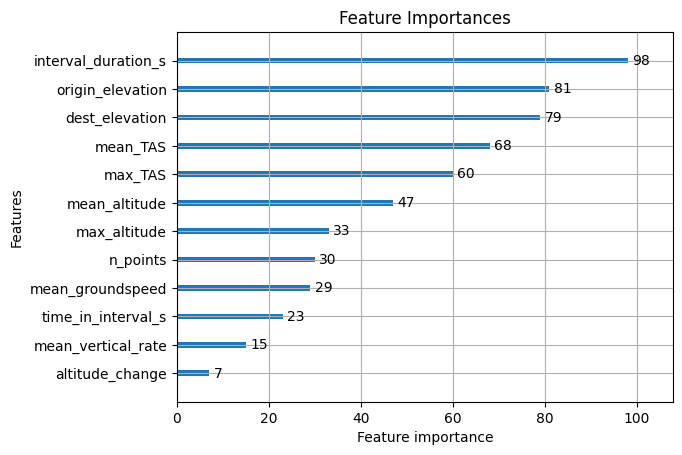

In [10]:
train_model(X_features, y_target, categorical_cols, n_trials=50, to_load="LightGBM Fuel Burn Prediction 2025-10-30T12:42:38.153171")